#### LSST generator single-band

In [2]:
# Instrument setting from pre-defined configurations

# from lenstronomy.SimulationAPI.ObservationConfig.DES import DES
from lenstronomy.SimulationAPI.ObservationConfig.LSST import LSST


# Instanciamos configuraciones de LSST para las bandas g, r, i
# Usamos una PSF gaussiana y asumimos 10 años de coadición de imágenes (survey completo)
LSST_g = LSST(band='g', psf_type='GAUSSIAN', coadd_years=10)
LSST_r = LSST(band='r', psf_type='GAUSSIAN', coadd_years=10)
LSST_i = LSST(band='i', psf_type='GAUSSIAN', coadd_years=10)
#lsst = [LSST_g, LSST_r, LSST_i]  # Agrupamos las configuraciones de LSST

In [3]:
#Extraemos las configuraciones para esa banda
kwargs_band = LSST_g.kwargs_single_band()

In [4]:
#Modelos usados para la lente, fuente y demás componentes
kwargs_model = {
    'lens_model_list': ['SIE', 'SHEAR'],
    'source_light_model_list': ['SERSIC_ELLIPSE'],
    'lens_light_model_list': [],
    'point_source_model_list': []
}

In [5]:
#Argumentos necesarios para la lente mencionada arriba
kwargs_lens = [
    {
        'theta_E': 1.2,       # radio de Einstein en arcsec
        'e1': 0.4, 'e2': -0.1,  # elipticidad (componentes cuadrupolares)
        'center_x': 0, 'center_y': 0  # posición de la lente
    },
    {
        'gamma1': 0.03, 'gamma2': 0.01,  # magnitud y orientación de la cizalla externa
        'ra_0': 0, 'dec_0': 0            # centro de referencia para la cizalla
    }
]

In [6]:
#Argumentos para la luz de la fuente
kwargs_source_mag = [{
    'magnitude': 21,
    'R_sersic': 0.4,
    'n_sersic': 1,
    'e1': 0.05,
    'e2': -0.05,
    'center_x': 0.1,
    'center_y': 0.05
}]

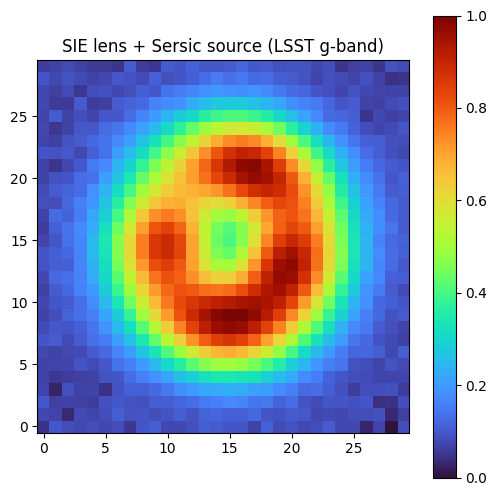

In [7]:

from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.Plots import plot_util
import matplotlib.pyplot as plt

# resolución
size = 6.0  # arcsec
pixel_scale = kwargs_band['pixel_scale']
numpix = int(round(size / pixel_scale))

# crear simulador
sim = SimAPI(numpix=numpix, kwargs_single_band=kwargs_band, kwargs_model=kwargs_model)

# convertir magnitudes a amplitudes
_, kwargs_source, _ = sim.magnitude2amplitude([], kwargs_source_mag, [])

# modelo de imagen
kwargs_numerics = {'point_source_supersampling_factor': 1}
imSim = sim.image_model_class(kwargs_numerics)

# generar imagen
image = imSim.image(kwargs_lens=kwargs_lens, kwargs_source=kwargs_source,
                    kwargs_lens_light=None, kwargs_ps=None)

# agregar ruido
image += sim.noise_for_model(image)

# mostrar
plt.figure(figsize=(6,6))
plt.imshow(plot_util.sqrt(image), origin='lower', cmap='turbo')
plt.title('SIE lens + Sersic source (LSST g-band)')
plt.colorbar()
plt.show()

Now, we can generate the model with subhalo

In [8]:
from astropy import units as u
from astropy.constants import G, c
from astropy.cosmology import FlatLambdaCDM
import numpy as np
from lenstronomy.Util.param_util import phi_q2_ellipticity, shear_polar2cartesian

In [9]:
#Cosmological parameters
z_lens, z_source = 0.881, 2.059
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.048)
D_d  = cosmo.angular_diameter_distance(z_lens)
D_s  = cosmo.angular_diameter_distance(z_source)
D_ds = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)

In [10]:
#LSST bands 
LSST_g = LSST(band='g', psf_type='GAUSSIAN', coadd_years=10)
#Parameters for that single band
kwargs_band = LSST_g.kwargs_single_band()

In [11]:
#Models used for the lens, source and other components for the subhalo case
kwargs_model_sub= {
    'lens_model_list': ['EPL', 'SIS', 'SHEAR_REDUCED'],
    'source_light_model_list': ['SERSIC_ELLIPSE']
}

#Kwards for the model without subhalo
kwargs_model_nosub= {
    'lens_model_list': ['EPL', 'SHEAR_REDUCED'],
    'source_light_model_list': ['SERSIC_ELLIPSE']
}

In [12]:
#Now the parameters for every model

##subhalo parameters, for an isothermal sphere (SIS) profile
mass_subhalo = 1e6  # Mass of the subhalo in solar masses
position_subhalo = [1.0,-1.0]  # Position of the subhalo in arcseconds

M_sub = mass_subhalo * u.M_sun  # Masa del subhalo
# Cálculo del radio de Einstein del subhalo en radianes
thetaE_sub_rad = np.sqrt(4*G*M_sub/c**2 * (D_ds/(D_d*D_s)))
# Conversión del radio de Einstein a arcosegundos
thetaE_sub = (thetaE_sub_rad * u.rad).to(u.arcsec).value
kwargs_sub = {'theta_E': thetaE_sub, 
'center_x': position_subhalo[0], 
'center_y': position_subhalo[1]} 

##kwargs for the main lens model

#Einstein radius and the gamma and gamma
theta_E_main, gamma_main = 1.452, 1.9
e1_main, e2_main = phi_q2_ellipticity(phi=np.deg2rad(-22.29), q=0.866)  # Elipticidad de la lente principal
kwargs_main = {
    'theta_E': theta_E_main, 'gamma': gamma_main,
    'e1': e1_main, 'e2': e2_main,
    'center_x': 0.0, 'center_y': -0.1  # Centro de la lente principal
} 

## shear reduced parameters
g1, g2 = shear_polar2cartesian(phi=np.deg2rad(107.9), gamma=0.015)  # Conversión de cizalla polar a cartesiana
kwargs_shear = {'gamma1': g1, 'gamma2': g2}

#Now we group the kwargs for both cases
kwargs_lens_sub = [kwargs_main, kwargs_sub, kwargs_shear]
kwargs_lens_nosub = [kwargs_main, kwargs_shear]


In [13]:
#Now the parameters for the source light, is the same for both cases
kwargs_source_mag = [{
    'magnitude': 21,
    'R_sersic': 0.4,
    'n_sersic': 1,
    'e1': 0.05,
    'e2': -0.05,
    'center_x': 0.1,
    'center_y': 0.05
}]

In [14]:
#Resolution and grid
size = 6.0  # arcsec
pixel_scale = kwargs_band['pixel_scale']
numpix = int(round(size / pixel_scale))

In [15]:
#Simulator for the models

# sim subhalo
sim_sub = SimAPI(numpix=numpix, 
             kwargs_single_band=kwargs_band, 
             kwargs_model=kwargs_model_sub)
#nosubhalo
sim_nosub = SimAPI(numpix=numpix, 
             kwargs_single_band=kwargs_band, 
             kwargs_model=kwargs_model_nosub)


In [16]:
#Convert magnitudes to amplitudes
_, kwargs_source_sub, _ = sim_sub.magnitude2amplitude([], kwargs_source_mag, [])
_, kwargs_source_nosub, _ = sim_nosub.magnitude2amplitude([], kwargs_source_mag, [])    

In [17]:
# numeric settings for subhalo case
kwargs_numerics = {'point_source_supersampling_factor': 1}
imSim_sub = sim_sub.image_model_class(kwargs_numerics)
imSim_nosub = sim_nosub.image_model_class(kwargs_numerics)

In [18]:
#Now we generate the images for both cases
#Image with subhalo
# generar imagen
image_sub = imSim_sub.image(kwargs_lens=kwargs_lens_sub, kwargs_source=kwargs_source,
                    kwargs_lens_light=None, kwargs_ps=None)

image_nosub = imSim_nosub.image(kwargs_lens=kwargs_lens_nosub, kwargs_source=kwargs_source,
                    kwargs_lens_light=None, kwargs_ps=None)

# add noise
image_sub += sim.noise_for_model(image_sub)
image_nosub += sim.noise_for_model(image_nosub)

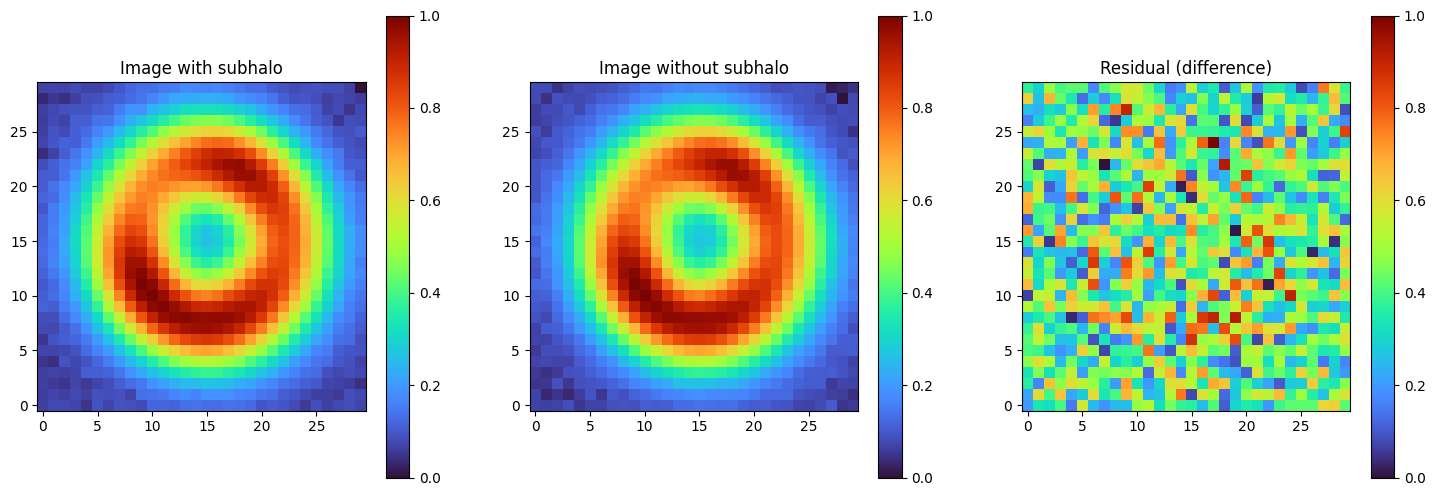

In [19]:
#now we plot both images side by side and the residual
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(plot_util.sqrt(image_sub), origin='lower', cmap='turbo')
plt.title('Image with subhalo')
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(plot_util.sqrt(image_nosub), origin='lower', cmap='turbo')      
plt.title('Image without subhalo')
plt.colorbar()
plt.subplot(1,3,3)
image_diff = image_sub - image_nosub
plt.imshow(plot_util.sqrt(np.abs(image_diff)), origin='lower', cmap='turbo')    
plt.title('Residual (difference)')
plt.colorbar()
plt.show()

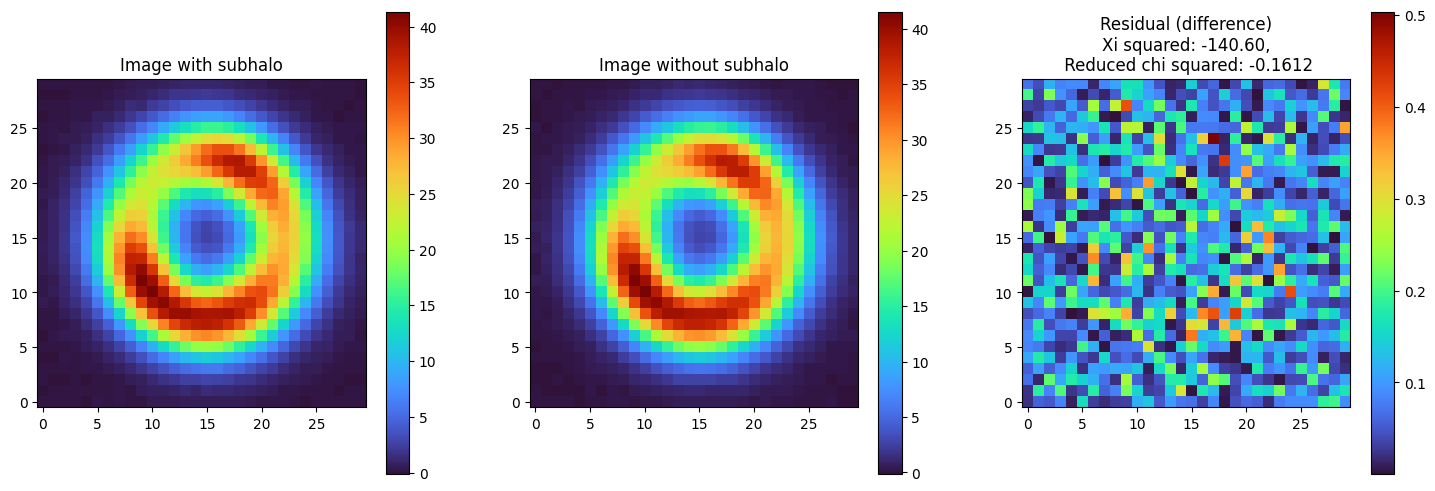

In [23]:
#now we plot both images side by side and the residual
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(image_sub, origin='lower', cmap='turbo')
plt.title('Image with subhalo')
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(image_nosub, origin='lower', cmap='turbo')      
plt.title('Image without subhalo')
plt.colorbar()
plt.subplot(1,3,3)
image_diff = image_sub - image_nosub
plt.imshow(np.abs(image_diff), origin='lower', cmap='turbo')    
plt.title('Residual (difference)')
plt.colorbar()
#We add the xi squared in the title
xi_squared = np.sum(((image_sub - image_nosub) ** 2) / (image_nosub + 1e-6))  # Adding a small value to avoid division by zero
#and the reduced chi squared
ndof = np.sum(image_nosub > 1e-6)  # Number of degrees of freedom
chi_squared_reduced = xi_squared / ndof
plt.title(f'Residual (difference)\nXi squared: {xi_squared:.2f},\n Reduced chi squared: {chi_squared_reduced:.4f}')

#change the scale to arsecseconds
plt.show()

In [21]:
#Now we compute the xi squared between both images
# Compute xi squared
xi_squared = np.sum(((image_sub - image_nosub) ** 2) / (image_nosub + 1e-6))  # Adding a small value to avoid division by zero
print(f'Xi squared between images with and without subhalo: {xi_squared}')   
#and the reduced chi squared
ndof = np.sum(image_nosub > 1e-6)  # Number of degrees of freedom
chi_squared_reduced = xi_squared / ndof
print(f'Reduced chi squared between images with and without subhalo: {chi_squared_reduced}')  

Xi squared between images with and without subhalo: -140.60409312427817
Reduced chi squared between images with and without subhalo: -0.16124322605995203


In [22]:
sqrt_image_sub = plot_util.sqrt(image_sub)
sqrt_image_nosub = plot_util.sqrt(image_nosub)

xi_squared_sqrt = np.sum(((sqrt_image_sub - sqrt_image_nosub) ** 2) / (sqrt_image_nosub + 1e-6))  # Adding a small value to avoid division by zero
print(f'Xi squared between sqrt images with and without subhalo: {xi_squared_sqrt}')
#and the reduced chi squared for the sqrt images
ndof_sqrt = np.sum(sqrt_image_nosub > 1e-6)  # Number of degrees of freedom
chi_squared_reduced_sqrt = xi_squared_sqrt / ndof_sqrt
print(f'Reduced chi squared between sqrt images with and without subhalo: {chi_squared_reduced_sqrt}')  

Xi squared between sqrt images with and without subhalo: 5139.576145434821
Reduced chi squared between sqrt images with and without subhalo: 5.716992375344629


   1. ¿Qué hacer con las demás bandas?

   2. ¿Utilizar $\sqrt{Imagen}$

   3. Una vez hecho un nuevo clasificador basado en el $\chi^2_{reducido}$, cómo integrar un criterio bayesiano?

   4. $\mathcal{L} \sim \chi^2$